In [1]:
%matplotlib inline
import sys

""" Uncomment the following line if you didn't install the library using pip:
"""
# sys.path.append('..')

from u8timeseries import Prophet, KthValueAgoBaseline, ExponentialSmoothing, TimeSeries
from u8timeseries.metrics import mape
from u8timeseries.backtesting import get_train_val_series, backtest_autoregressive_model

import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestRegressor

## Read data

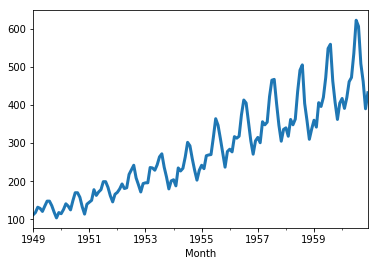

In [2]:
df = pd.read_csv('AirPassengers.csv')
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')
series.pd_series().plot(lw=3)

## Build three models and an error function

In [3]:
model_es = ExponentialSmoothing()
model_pr = Prophet()
# model_rf = SupervisedTimeSeriesModel(RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=0))
model_bl = KthValueAgoBaseline(K=1)

"""
def timeit(f):
    def wrapper(*args, **kwargs):
        tic = time.time()
        res = f(*args, **kwargs)
        tac = time.time()
        print('Time taken: %.2f s.' % (tac - tic))
        return res
    return wrapper
"""

"\ndef timeit(f):\n    def wrapper(*args, **kwargs):\n        tic = time.time()\n        res = f(*args, **kwargs)\n        tac = time.time()\n        print('Time taken: %.2f s.' % (tac - tic))\n        return res\n    return wrapper\n"

## Backtest the models on the data
Simulate 12-months ahead predictions done in the past, starting in January 1955.

In [4]:
tic = time.time()
train_val_series = get_train_val_series(series, start=pd.Timestamp('19550101'), nr_points_in_val=12)
backtest_autoregressive_model(model_es, train_val_series, mape)
tac = time.time()
print('Backtested Exponential Smoothing in %.2f s.' % (tac-tic))

"""
tic = time.time()
backtest_results_pr = model_pr.backtest(df, '#Passengers', 'Month', 'month', 
                                        datetime(1955, 1, 1), 12, error_func)
tac = time.time()
print('Backtested Prophet in %.2f s.' % (tac-tic))

tic = time.time()
backtest_results_rf = model_rf.backtest(df, '#Passengers', 'Month', 'month',
                                        datetime(1955, 1, 1), 12, error_func)
tac = time.time()
print('Backtested Random Forests in %.2f s.' % (tac-tic))

tic = time.time()
backtest_results_bl = model_bl.backtest(df, '#Passengers', 'Month', 'month',
                                        datetime(1955, 1, 1), 12, error_func)
tac = time.time()
print('Backtested Baseline in %.2f s.' % (tac-tic))
"""


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Plot backtesting results

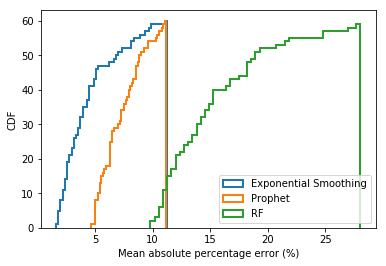

In [5]:
plt.hist(backtest_results_es, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Exponential Smoothing');
plt.hist(backtest_results_pr, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Prophet');
plt.hist(backtest_results_rf, bins=50, cumulative=True, histtype='step', 
         lw=2, label='RF');

plt.xlabel('Mean absolute percentage error (%)')
plt.ylabel('CDF')
plt.legend(loc=4)

## Let's make an actual forecast!
Since Exponential Smoothing is better in backtests, let's use this one.

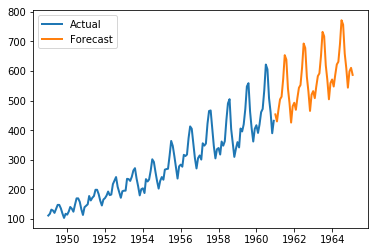

In [9]:
model_es.fit(df, '#Passengers', 'Month', 'month')
pred_df = model_es.predict(n = 50)

plt.plot(df['Month'], df['#Passengers'], lw=2, label='Actual')
plt.plot(pred_df['Month'], pred_df['yhat'], lw=2, label='Forecast')
plt.legend()

## Example of forecasting using a supervised model and extra features
Here we show how to forecast with a supervised model, with an additional dummy (constant) feature. Note that in this case the resulting forecasts are not so interesting, as random forest simply predicts the last value because our extra feature is not informative.

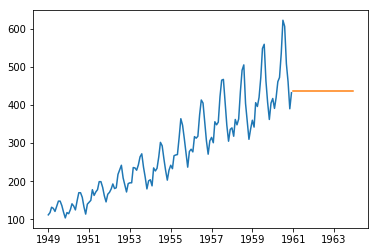

In [12]:
df_with_feature = df.copy()
df_with_feature['dummy_feature'] = [1 for _ in range(len(df))]

model_rf.fit(df_with_feature, '#Passengers', 'Month', 'month', feature_columns=['dummy_feature'])

# Predict for three years
test_dates = [datetime(1961, m, 1) for m in range(1, 13)] + \
             [datetime(1962, m, 1) for m in range(1, 13)] + \
             [datetime(1963, m, 1) for m in range(1, 13)]

test_df = pd.DataFrame({'Month': test_dates})
test_df['dummy_feature'] = [1 for _ in range(len(test_df))]

predicted_df = model_rf.predict(test_df)

plt.figure()
plt.plot(df['Month'], df['#Passengers'])
plt.plot(predicted_df['Month'], predicted_df['yhat'])